In [1]:
import pandas as pd
import numpy as np
import torch 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

In [2]:
device = torch.device('cuda:0')

In [3]:
path = '/home/jwelliav/Documents/Crypto/data/Binance/AVAX_USDT.csv'

df = pd.read_csv(path, names = ['timestamp','open','high','low','close','volume'])
df = df.set_index('timestamp')

In [4]:
df['pct_change'] = df.close.pct_change()
df['log_ret'] = np.log(df.close) - np.log(df.close.shift(1))
df['vol_usdt_K'] = (((df['open'] + df['close'])/2)*df['volume'])/1000
df = df.iloc[1:-1]

tmp = [x/1000 for x in (df.index)]
l = list(map(datetime.fromtimestamp,tmp))

df['datetime'] = l

In [6]:
df.columns = [x + '_avax' for x in df.columns]

In [8]:
df.head()

,open,high,low,close,volume,pct_change,log_ret,vol_usdt_K,datetime
timestamp,,,,,,,,,
1600756320000,4.2500,4.4351,4.0611,4.1021,137106.97,-0.041005,-0.041870,572.565562,2020-09-22 15:32:00
1600756380000,4.1027,4.2000,4.0061,4.1699,117775.14,0.016528,0.016393,487.153312,2020-09-22 15:33:00
1600756440000,4.1699,4.1990,4.1076,4.1800,72788.25,0.002422,0.002419,303.887304,2020-09-22 15:34:00
1600756500000,4.1704,4.3879,4.0487,4.3350,115621.12,0.037081,0.036410,491.701937,2020-09-22 15:35:00
1600756560000,4.3350,4.3351,4.2000,4.2900,67848.12,-0.010381,-0.010435,292.595017,2020-09-22 15:36:00


In [ ]:
tmp = df[['datetime','close']].set_index('datetime')

plt.figure(figsize=(12,6))
sns.lineplot(data= tmp.close[::60*24].pct_change())
plt.title('Daily pct change of AVAX in USDT')
plt.ylabel('Price in USDT')

Text(0, 0.5, 'Price in USDT')

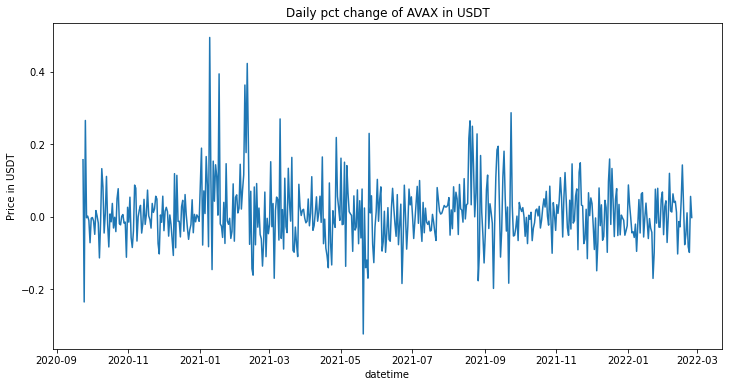

In [9]:
tmp = df[['datetime','close']].set_index('datetime')

plt.figure(figsize=(12,6))
sns.lineplot(data= tmp.close[::60*24].pct_change())
plt.title('Daily pct change of AVAX in USDT')
plt.ylabel('Price in USDT')

In [68]:
class avax_usdt_dataset(torch.utils.data.Dataset):
    
    def __init__(self,df,lag):
        
        self.lag = lag
        y = df['close'][1:]
        self.df = df.iloc[:-1,:]
        self.X = self.df[['open','high','low','close','vol_usdt_K']].values
        
        self.y = y.values
    
    def __getitem__(self,idx):
        
        m = self.X.shape[1]
        if idx < self.lag:
            r = self.lag - idx - 1
            tmp1 = np.zeros((r,m))
            tmp2 = self.X[:idx + 1]
            x = np.concatenate((tmp1,tmp2))
            
        if idx >= self.lag:
            x = self.X[idx-self.lag+1 : idx+1] 
            
        x = x.flatten()
            
        x = torch.tensor(x)  
        
        y = torch.tensor(self.y[idx])
        
        return(x.float().to(device),y.float().to(device))
        
    def __len__(self):
        
        return(len(self.df))
    

In [69]:
class simple_model(nn.Module):
    
    def __init__(self,hidden_size):
        super().__init__()
        self.fc1 = nn.LazyLinear(hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.LazyLinear(1)
        self.relu2 = nn.ReLU()
        
    def forward(self,x):
        x = self.relu1(self.fc1(x))
        y = self.relu2(self.fc2(x))
        return(y)

In [79]:
class baseline_model(nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self,x):
        z = torch.tensor([t[-2] for t in x])
        return(z)

In [86]:
base_model = baseline_model()

In [87]:
num_epochs = 10

In [88]:
f = simple_model(10).cuda()

In [89]:
criterion = nn.MSELoss()
optimizer = optim.Adam(f.parameters(),lr = 0.001)

In [90]:
## training step 

tscv = TimeSeriesSplit(gap = 72*60, n_splits = 5)

results = {}

for r,(trainidx,testidx) in enumerate(tscv.split(df)): 
    
    ds = avax_usdt_dataset(df.iloc[trainidx],10)
    trainloader = DataLoader(ds, batch_size = 64, shuffle= False)
    
    #f.train()
    
    for i in range(num_epochs):
        
        running_loss = 0.0
        
        for j,batch in enumerate(trainloader):
            
            inputs,labels = batch
            outputs = f(inputs)
            
            optimizer.zero_grad()
            
            loss = criterion(labels,torch.squeeze(outputs))
            
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
        print(f'[{i + 1}] loss: {running_loss / len(trainloader):.5f}')
        running_loss = 0.0
    
    print(f'Finished Training for split {r+1}')
    
    ds = avax_usdt_dataset(df.iloc[testidx],10)
    testloader = DataLoader(ds, batch_size = 64, shuffle= False)
    
    #f.eval()
    
    results[r] = []
    
    with torch.no_grad():
        
        running_loss = 0.0
        baseline_running_loss = 0.0
        
        for batch in (testloader):
                
                inputs,labels = batch
                outputs = f(inputs)
                
                results[r].append((inputs,labels,outputs))
                
                baseline_pred = base_model(inputs)
                baseline_loss = criterion(labels,baseline_pred.to(device))
                
                loss = criterion(labels,outputs)
                
                # print statistics
                running_loss += loss.item()
                baseline_running_loss += baseline_loss.item()
                
        print(f'Model Testing loss: {running_loss / len(testloader):.5f}')  
        print(f'Baseline Testing loss: {baseline_running_loss / len(testloader):.5f}')
        print(f'Finished Testing for split {r+1}')

[1] loss: 0.63504
[2] loss: 0.23860
[3] loss: 0.06861
[4] loss: 0.04673
[5] loss: 0.03573
[6] loss: 0.03168
[7] loss: 0.02115
[8] loss: 0.02797
[9] loss: 0.01364
[10] loss: 0.02198
Finished Training for split 1


/home/jwelliav/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Model Testing loss: 5.39244
Baseline Testing loss: 0.00835
Finished Testing for split 1
[1] loss: 0.09795
[2] loss: 0.08009
[3] loss: 0.06895
[4] loss: 0.06653
[5] loss: 0.06847
[6] loss: 0.06869
[7] loss: 0.06852
[8] loss: 0.06817
[9] loss: 0.06770
[10] loss: 0.06723
Finished Training for split 2
Model Testing loss: 0.18187
Baseline Testing loss: 0.00739
Finished Testing for split 2
[1] loss: 0.06595
[2] loss: 0.06160
[3] loss: 0.04870
[4] loss: 0.04928
[5] loss: 0.04736
[6] loss: 0.04947
[7] loss: 0.04595
[8] loss: 0.05049
[9] loss: 0.04394
[10] loss: 0.05114
Finished Training for split 3
Model Testing loss: 0.17003
Baseline Testing loss: 0.00433
Finished Testing for split 3
[1] loss: 0.05140
[2] loss: 0.04905
[3] loss: 0.05305
[4] loss: 0.07143
[5] loss: 0.04117
[6] loss: 0.04309
[7] loss: 0.03941
[8] loss: 0.04423
[9] loss: 0.05096
[10] loss: 0.04593
Finished Training for split 4
Model Testing loss: 1.33254
Baseline Testing loss: 0.02878
Finished Testing for split 4
[1] loss: 0.084

In [19]:
#torch.save(f.state_dict(),'f_attempt_1')

In [37]:
f.load_state_dict(torch.load('/home/jwelliav/Documents/Crypto/models/pytorch_starter/f_attempt_1'))

<All keys matched successfully>

In [22]:
ds = avax_usdt_dataset(df,10)
trainloader = DataLoader(ds, batch_size = 64, shuffle= False) 

In [23]:
batch = next(iter(trainloader))

In [30]:
batch[0][0][-2]

tensor(4.1021, device='cuda:0')

In [41]:
base_model(batch[0])

tensor([  5.2102,   5.2132,   5.0600,   5.0918, 187.6034,   5.0918,   5.0996,
          4.8300,   4.8900, 422.7390,   4.8898,   4.8900,   4.6938,   4.7801,
        290.0742,   4.7981,   4.8390,   4.6666,   4.8250, 300.3293,   4.8140,
          4.9900,   4.8121,   4.9312, 337.5367,   4.9141,   5.1500,   4.9140,
          5.0992, 455.5319,   5.0992,   5.1000,   4.9375,   5.0642, 238.6149,
          5.0642,   5.0642,   4.9801,   4.9916, 143.6602,   4.9915,   4.9915,
          4.8443,   4.8803, 106.4969,   4.8803,   5.0204,   4.8801,   4.9791,
        106.7847], device='cuda:0')

In [42]:
batch[0]

tensor([[  0.0000,   0.0000,   0.0000,  ...,   4.0611,   4.1021, 572.5656],
        [  0.0000,   0.0000,   0.0000,  ...,   4.0061,   4.1699, 487.1533],
        [  0.0000,   0.0000,   0.0000,  ...,   4.1076,   4.1800, 303.8873],
        ...,
        [  5.1976,   5.2366,   5.1415,  ...,   4.8443,   4.8803, 106.4969],
        [  5.2102,   5.2132,   5.0600,  ...,   4.8801,   4.9791, 106.7847],
        [  5.0918,   5.0996,   4.8300,  ...,   4.8085,   4.9250, 100.7028]],
       device='cuda:0')

In [45]:
torch.tensor([x[-2] for x in batch[0]])

tensor([4.1021, 4.1699, 4.1800, 4.3350, 4.2900, 4.5602, 4.8480, 4.8342, 4.8090,
        4.9600, 5.1257, 5.2046, 5.4000, 5.5274, 5.2291, 5.4563, 5.4073, 5.5494,
        5.3270, 5.4249, 5.3851, 5.2499, 5.2000, 4.9737, 4.8244, 4.7714, 4.9016,
        4.8811, 4.9283, 4.8017, 4.7175, 4.5268, 4.3388, 4.5086, 4.6105, 4.6906,
        4.4816, 4.4200, 4.3890, 4.3800, 4.4306, 4.4523, 4.4593, 4.5642, 5.0000,
        4.9435, 5.2050, 5.0713, 5.1462, 5.1419, 5.3040, 5.1950, 5.2102, 5.0918,
        4.8900, 4.7801, 4.8250, 4.9312, 5.0992, 5.0642, 4.9916, 4.8803, 4.9791,
        4.9250])

In [52]:
base_model(batch[0])

tensor([4.1021, 4.1699, 4.1800, 4.3350, 4.2900, 4.5602, 4.8480, 4.8342, 4.8090,
        4.9600, 5.1257, 5.2046, 5.4000, 5.5274, 5.2291, 5.4563, 5.4073, 5.5494,
        5.3270, 5.4249, 5.3851, 5.2499, 5.2000, 4.9737, 4.8244, 4.7714, 4.9016,
        4.8811, 4.9283, 4.8017, 4.7175, 4.5268, 4.3388, 4.5086, 4.6105, 4.6906,
        4.4816, 4.4200, 4.3890, 4.3800, 4.4306, 4.4523, 4.4593, 4.5642, 5.0000,
        4.9435, 5.2050, 5.0713, 5.1462, 5.1419, 5.3040, 5.1950, 5.2102, 5.0918,
        4.8900, 4.7801, 4.8250, 4.9312, 5.0992, 5.0642, 4.9916, 4.8803, 4.9791,
        4.9250])

In [58]:
batch[1].shape

torch.Size([64])

In [ ]:
#torch.unsqueeze(batch[1],1)

In [77]:
torch.squeeze(f(batch[0]))

tensor([3.5632, 3.5642, 3.5764, 3.5671, 3.5741, 3.5733, 3.5837, 3.5798, 3.5749,
        3.5811, 3.5839, 3.6073, 3.6100, 3.6013, 3.5586, 3.5900, 3.6200, 3.6051,
        3.5645, 3.5674, 3.5991, 3.6140, 3.5867, 3.5912, 3.5861, 3.6500, 3.5920,
        3.5895, 3.5996, 3.6242, 3.5929, 3.5769, 3.6028, 3.5898, 3.5892, 3.5877,
        3.5899, 3.5903, 3.5900, 3.6139, 3.6003, 3.5893, 3.5850, 3.5990, 3.5905,
        3.5750, 3.5725, 3.5695, 3.5705, 3.6055, 3.5572, 3.5712, 3.6018, 3.6052,
        3.5799, 3.5734, 3.6193, 3.5916, 3.5890, 3.5969, 3.5979, 3.5998, 3.5998,
        3.5995], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [82]:
criterion(batch[1],baseline_pred.to(device))

tensor(0.0075, device='cuda:0')

In [84]:
len(trainloader)

1884